In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

# geopandas imported (optional mapping/geo-use)
import geopandas as gpd

plt.rcParams['figure.figsize'] = (12, 5)
sns.set_style('darkgrid')


In [2]:
DATA_PATH = "data.xlsx" # path to our .xlsx
SHEET_NAME = 0 # sheet name

# Column names in our file : TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD, X, Y, Latitude, Longitude, Hour, Minute, Day, Date

DATE_COL = "Date" 
TIME_HOUR_COL = "Hour" # optional hour column
TIME_MIN_COL = "Minute" # optional minute column

# Aggregation level for creating the target 'y': 'day' (daily counts), 'hour' (per-hour counts), or 'neighbourhood_day' (counts per neighbourhood per day)
AGG_LEVEL = 'day'

# If you prefer to forecast counts per-neighbourhood set AGG_LEVEL = 'neighbourhood_day' and optionally set TARGET_NEIGH = 'CENTRAL' or leave None to aggregate all neighbourhoods separately later.
TARGET_NEIGH = None
FREQ = "D" # data frequency (e.g. 'D' daily, 'H' hourly)
HORIZON = 14 # forecast horizon (in periods of FREQ)
RANDOM_STATE = 42

In [3]:
def load_data(path=DATA_PATH, sheet_name=SHEET_NAME, date_col=DATE_COL, hour_col=TIME_HOUR_COL, minute_col=TIME_MIN_COL, agg_level=AGG_LEVEL, target_neigh=TARGET_NEIGH, freq=FREQ):
    """Load excel file, parse dates, and aggregate into a DataFrame indexed by datetime with a single column 'y'.

    agg_level options:
    - 'day' : daily counts (one row per calendar day)
    - 'hour': counts per hour (combines Date + Hour + Minute if present)
    - 'neighbourhood_day': counts per neighbourhood per day (returns a MultiIndex or aggregated single neighbourhood if target_neigh provided)
    """
    
    raw = pd.read_excel(path, sheet_name=sheet_name)
    df = raw.copy()

    # Ensure columns exist
    expected = {date_col, 'TYPE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'X', 'Y', 'Latitude', 'Longitude', hour_col, minute_col, 'Day'}

    # Parse Date
    # Try common parsing strategies: if Date column already datetime-like, keep; else try to parse
    try:
        df[date_col] = pd.to_datetime(df[date_col])
    except Exception:
        df[date_col] = pd.to_datetime(df[date_col], dayfirst=False, errors='coerce')

    # Build a datetime column if hour/minute are present and user asks for hourly aggregation
    if hour_col in df.columns:
    # if minute column not present, fill with 0
        if minute_col not in df.columns:
            df[minute_col] = 0
        # coerce hour/minute to ints and fill NaNs with 0
        df[hour_col] = pd.to_numeric(df[hour_col], errors='coerce').fillna(0).astype(int)
        df[minute_col] = pd.to_numeric(df[minute_col], errors='coerce').fillna(0).astype(int)
        df['datetime'] = df[date_col].dt.normalize() + pd.to_timedelta(df[hour_col], unit='h') + pd.to_timedelta(df[minute_col], unit='m')
    else:
        df['datetime'] = df[date_col]

    # Now aggregate according to agg_level
    if agg_level == 'day':
        # group by date (calendar day) and count events
        df['day_only'] = df['datetime'].dt.floor('D')
        agg = df.groupby('day_only').size().rename('y').to_frame()
        agg.index = pd.DatetimeIndex(agg.index)
        agg = agg.asfreq(freq)
        return agg
    elif agg_level == 'hour':
        df['hour_only'] = df['datetime'].dt.floor('H')
        agg = df.groupby('hour_only').size().rename('y').to_frame()
        agg.index = pd.DatetimeIndex(agg.index)
        agg = agg.asfreq(freq)
        return agg
    elif agg_level == 'neighbourhood_day':
        df['day_only'] = df['datetime'].dt.floor('D')
        if target_neigh is not None:
            sub = df[df['NEIGHBOURHOOD'] == target_neigh]
            agg = sub.groupby('day_only').size().rename('y').to_frame()
            agg.index = pd.DatetimeIndex(agg.index)
            agg = agg.asfreq(freq)
            return agg
        else:
            # return a DataFrame with MultiIndex (NEIGHBOURHOOD, day) or pivoted wide format
            agg = df.groupby(['NEIGHBOURHOOD', 'day_only']).size().rename('y').reset_index()
            # pivot to wide so each neighbourhood becomes a column (useful if you want to forecast multiple series)
            pivot = agg.pivot(index='day_only', columns='NEIGHBOURHOOD', values='y').fillna(0)
            pivot.index = pd.DatetimeIndex(pivot.index)
            pivot = pivot.asfreq(freq)
            return pivot
    else:
        raise ValueError(f"Unknown agg_level: {agg_level}")

In [4]:
def train_test_split_time_series(df, test_size_horizon=HORIZON):
    """Simple tail split: keep last HORIZON periods for test."""
    train = df.iloc[:-test_size_horizon]
    test = df.iloc[-test_size_horizon:]
    return train, test

In [5]:
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

def evaluate_forecast(y_true, y_pred):
    """Evaluate forecast arrays/Series. Aligns indices if pandas Series provided and handles older sklearn versions.
    Returns dict with MAE, RMSE, MAPE.
    """
    # Convert to pandas Series for safe alignment
    try:
        import pandas as _pd
        if isinstance(y_true, _pd.Series):
            y_true_s = y_true.copy()
        else:
            y_true_s = _pd.Series(y_true)
        if isinstance(y_pred, _pd.Series):
            y_pred_s = y_pred.reindex(y_true_s.index)
        else:
            y_pred_s = _pd.Series(y_pred, index=y_true_s.index)
    except Exception:
        # fallback to numpy
        y_true_s = np.array(y_true)
        y_pred_s = np.array(y_pred)

    # Drop any NaNs that might appear after alignment
    if hasattr(y_true_s, 'dropna'):
        mask = ~(y_true_s.isna() | y_pred_s.isna())
        y_true_arr = y_true_s[mask].values
        y_pred_arr = y_pred_s[mask].values
    else:
        # numpy arrays
        mask = ~ (np.isnan(y_true_s) | np.isnan(y_pred_s))
        y_true_arr = y_true_s[mask]
        y_pred_arr = y_pred_s[mask]

    mae = mean_absolute_error(y_true_arr, y_pred_arr)
    # Some versions of scikit-learn don't support `squared` kwarg; compute RMSE manually to be safe
    mse = mean_squared_error(y_true_arr, y_pred_arr)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true_arr - y_pred_arr) / (y_true_arr + 1e-9))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

In [6]:
# Exploratory Data Analysis (EDA)
def eda_report(df):
    print("Data range:", df.index.min(), "to", df.index.max())
    print("Missing values:")
    print(df.isna().sum())
    display(df.describe())

    # Plot
    fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    df['y'].plot(ax=ax[0], title='Time series (raw)')
    ax[0].set_ylabel('y')

    df['y'].rolling(7).mean().plot(ax=ax[1], label='7-period MA')
    df['y'].rolling(30).mean().plot(ax=ax[1], label='30-period MA')
    ax[1].legend()
    ax[1].set_title('Moving averages')
    plt.show()

    # Decomposition (additive)
    try:
        decomposition = seasonal_decompose(df['y'].dropna(), model='additive', period=None)
        decomposition.plot()
        plt.suptitle('Seasonal Decompose')
        plt.show()
    except Exception as e:
        print('Decomposition failed:', e)

    # Stationarity test
    print('\nAugmented Dickey-Fuller test:')
    adf_res = adfuller(df['y'].dropna(), autolag='AIC')
    print(f'ADF Statistic: {adf_res[0]:.4f}')
    print(f'p-value: {adf_res[1]:.4f}')
    print('Critical Values:')
    for k, v in adf_res[4].items():
        print(f' {k}: {v:.4f}')

In [7]:
# Missing-value handling + simple imputation

def fill_missing(df, method='interpolate'):
    df = df.copy()
    if method == 'ffill':
        df['y'] = df['y'].fillna(method='ffill')
    elif method == 'bfill':
        df['y'] = df['y'].fillna(method='bfill')
    else:
        df['y'] = df['y'].interpolate(method='time')
    # If still NaNs at ends, forward/backfill
    df['y'] = df['y'].fillna(method='ffill').fillna(method='bfill')
    return df

In [8]:
# Feature engineering for ML models (lag features, rolling stats, calendar)

def create_features(df, lags=[1,2,3,7,14], rolling_windows=[7,14,30]):
    """Return DataFrame with engineered features. Index must be datetime and df has column 'y'"""
    X = df.copy()
    for lag in lags:
        X[f'lag_{lag}'] = X['y'].shift(lag)
    for rw in rolling_windows:
        X[f'roll_mean_{rw}'] = X['y'].shift(1).rolling(rw).mean()
        X[f'roll_std_{rw}'] = X['y'].shift(1).rolling(rw).std()

    # Calendar features
    X['month'] = X.index.month
    X['day'] = X.index.day
    X['weekday'] = X.index.weekday
    X['is_month_start'] = X.index.is_month_start.astype(int)
    X['is_month_end'] = X.index.is_month_end.astype(int)

    # Drop rows with NaN (from shifting)
    X = X.dropna()
    y = X.pop('y')
    return X, y

In [9]:
# Baseline naive forecasts

def naive_forecast(train, horizon=HORIZON):
    last = train['y'].iloc[-1]
    return pd.Series([last] * horizon, index=pd.date_range(start=train.index[-1] + pd.tseries.frequencies.to_offset(FREQ), periods=horizon, freq=FREQ))

def seasonal_naive_forecast(train, horizon=HORIZON, seasonal_lag=7):
    # repeat last season
    idx = pd.date_range(start=train.index[-1] + pd.tseries.frequencies.to_offset(FREQ), periods=horizon, freq=FREQ)
    vals = []
    for i in range(horizon):
        vals.append(train['y'].iloc[-seasonal_lag + (i % seasonal_lag)])
    return pd.Series(vals, index=idx)

In [10]:
# SARIMAX modeling (classical statistical model)

def sarimax_forecast(train, order=(1,0,0), seasonal_order=(0,0,0,0), exog=None, horizon=HORIZON):
    model = SARIMAX(train['y'], order=order, seasonal_order=seasonal_order, exog=exog, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    start = len(train)
    end = len(train) + horizon - 1
    pred = res.predict(start=start, end=end)
    # Build index for forecast
    idx = pd.date_range(start=train.index[-1] + pd.tseries.frequencies.to_offset(FREQ), periods=horizon, freq=FREQ)
    pred.index = idx
    return pred, res

In [11]:
# MODAL training using XGBoost

def train_xgb(train, test, params=None, n_iter=20):
    """Train an XGBoost model without relying on fit-time early stopping (compatible with older xgboost versions).
    Returns trained model and a Series of recursive forecasts for the test index.
    """
    X_train, y_train = create_features(train)
    X_test_all, y_test_all = create_features(pd.concat([train.tail(max(60, len(train)//5)), test]))
    # Align validation split: keep last len(test) rows as validation set from X_test_all
    split_point = len(X_test_all) - len(test)
    X_valid = X_test_all.iloc[split_point:]
    y_valid = y_test_all.iloc[split_point:]
    # Remove validation rows from training set if they overlap
    X_train = X_train.drop(X_valid.index, errors='ignore')
    y_train = y_train.drop(y_valid.index, errors='ignore')

    if params is None:
        params = {
            'n_estimators': 500,
            'learning_rate': 0.05,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE
        }

    model = xgb.XGBRegressor(**params)
    # Some xgboost versions don't accept early_stopping_rounds or eval_set as kwargs on sklearn API's fit.
    # To keep compatibility, call fit without those kwargs. If you have a newer xgboost version, uncomment the
    # eval_set line below and comment the simple fit line.
    try:
        # Preferred (when supported): enable early stopping during fit
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)
    except TypeError:
        # Fallback for older versions: simple fit without early stopping
        model.fit(X_train, y_train)

    # forecast for the test index by recursively creating features
    preds = []
    history = pd.concat([train[['y']], test[['y']].copy() * np.nan])
    for t in range(len(test)):
        features_row = build_feature_row(history, position=len(train) + t, lags=[1,2,3,7,14], rolling_windows=[7,14,30])
        features_row = features_row.values.reshape(1, -1)
        pred = model.predict(features_row)[0]
        preds.append(pred)
        # insert predicted value into history so next step uses it as lag
        history.iloc[len(train) + t, history.columns.get_loc('y')] = pred

    preds = pd.Series(preds, index=test.index)
    return model, preds

def build_feature_row(history_df, position, lags=[1,2,3,7,14], rolling_windows=[7,14,30]):
    # position is integer index into history_df (0-based)
    row_date = history_df.index[position]
    row = {}
    for lag in lags:
        row[f'lag_{lag}'] = history_df['y'].iloc[position - lag]
    for rw in rolling_windows:
        start = max(0, position - rw)
        window = history_df['y'].iloc[start:position]
        row[f'roll_mean_{rw}'] = window.mean()
        row[f'roll_std_{rw}'] = window.std()
    row['month'] = row_date.month
    row['day'] = row_date.day
    row['weekday'] = row_date.weekday()
    row['is_month_start'] = int(row_date.is_month_start)
    row['is_month_end'] = int(row_date.is_month_end)
    return pd.Series(row)

In [12]:
# Model explainability - feature importance (permutation importance)

def permutation_importance(model, X, y, n_repeats=10):
    from sklearn.inspection import permutation_importance as pi
    res = pi(model, X, y, n_repeats=n_repeats, random_state=RANDOM_STATE, n_jobs=-1)
    imp = pd.DataFrame({'feature': X.columns, 'importance_mean': res.importances_mean, 'importance_std': res.importances_std})
    imp = imp.sort_values('importance_mean', ascending=False)
    return imp

In [13]:
def run_pipeline():
    # 1) Load
    df = load_data()
    eda_report(df)

    # 2) Fill missing
    df_filled = fill_missing(df)

    # 3) Split
    train, test = train_test_split_time_series(df_filled)
    print('\nTrain length:', len(train), 'Test length:', len(test))

    # 4) Baseline
    naive_pred = naive_forecast(train)
    sn_pred = seasonal_naive_forecast(train)
    print('\nBaseline evaluations:')
    try:
        print('Naive:', evaluate_forecast(test['y'], naive_pred))
        print('Seasonal naive:', evaluate_forecast(test['y'], sn_pred))
    except Exception as e:
        print('Baseline evaluation failed:', e)

    xgb_model = None
    sarima_pred = None
    xgb_preds = None

    # 5) SARIMAX (quick try) - tune orders manually or via grid search
    try:
        sarima_pred, sarima_res = sarimax_forecast(train, order=(1,1,1), seasonal_order=(1,1,1,12), horizon=len(test))
        print('SARIMAX evaluation:', evaluate_forecast(test['y'], sarima_pred))
    except Exception as e:
        print('SARIMAX failed:', e)
        sarima_pred = None

    # 6) XGBoost
    try:
        xgb_model, xgb_preds = train_xgb(train, test)
        if xgb_preds is not None:
            print('XGBoost evaluation:', evaluate_forecast(test['y'], xgb_preds))
    except Exception as e:
        print('XGBoost failed:', e)
        xgb_preds = None

    # 7) Plot results
    plt.figure(figsize=(14,6))
    plt.plot(train.index, train['y'], label='train')
    plt.plot(test.index, test['y'], label='actual')
    if naive_pred is not None:
        plt.plot(naive_pred.index, naive_pred.values, label='naive')
    if sn_pred is not None:
        plt.plot(sn_pred.index, sn_pred.values, label='seasonal naive')
    if sarima_pred is not None:
        plt.plot(sarima_pred.index, sarima_pred.values, label='SARIMAX')
    if xgb_preds is not None:
        plt.plot(xgb_preds.index, xgb_preds.values, label='XGBoost')
    plt.legend()
    plt.title('Forecast comparison')
    plt.show()

    # 8) Feature importance for XGBoost
    try:
        if xgb_model is not None and hasattr(xgb_model, 'get_booster'):
            X_train_full, y_train_full = create_features(pd.concat([train, test]))
            # if model provides feature names, use them, else fallback
            try:
                feature_names = xgb_model.get_booster().feature_names
                imp = permutation_importance(xgb_model, X_train_full[feature_names], y_train_full)
            except Exception:
                try:
                    fi = pd.DataFrame({'feature': X_train_full.columns, 'importance': xgb_model.feature_importances_})
                    display(fi.sort_values('importance', ascending=False).head(20))
                    imp = None
                except Exception:
                    imp = None
            if imp is not None:
                display(imp.head(20))
    except Exception as e:
        print('Feature importance failed:', e)

    # 9) Save model
    try:
        if xgb_model is not None:
            import joblib
            joblib.dump(xgb_model, 'xgb_model.joblib')
            print('Saved XGBoost model to xgb_model.joblib')
        else:
            print('No XGBoost model to save.')
    except Exception as e:
        print('Saving model failed:', e)

    return {
        'df': df,
        'train': train,
        'test': test,
        'naive': naive_pred,
        'seasonal_naive': sn_pred,
        'sarima': sarima_pred,
        'xgb_preds': xgb_preds,
        'xgb_model': xgb_model
        }

Data range: 1999-01-01 00:00:00 to 2011-12-31 00:00:00
Missing values:
y    0
dtype: int64


,y
count,4748.000000
mean,99.950505
std,27.255771
min,32.000000
25%,81.000000
50%,96.000000
75%,117.000000
max,649.000000


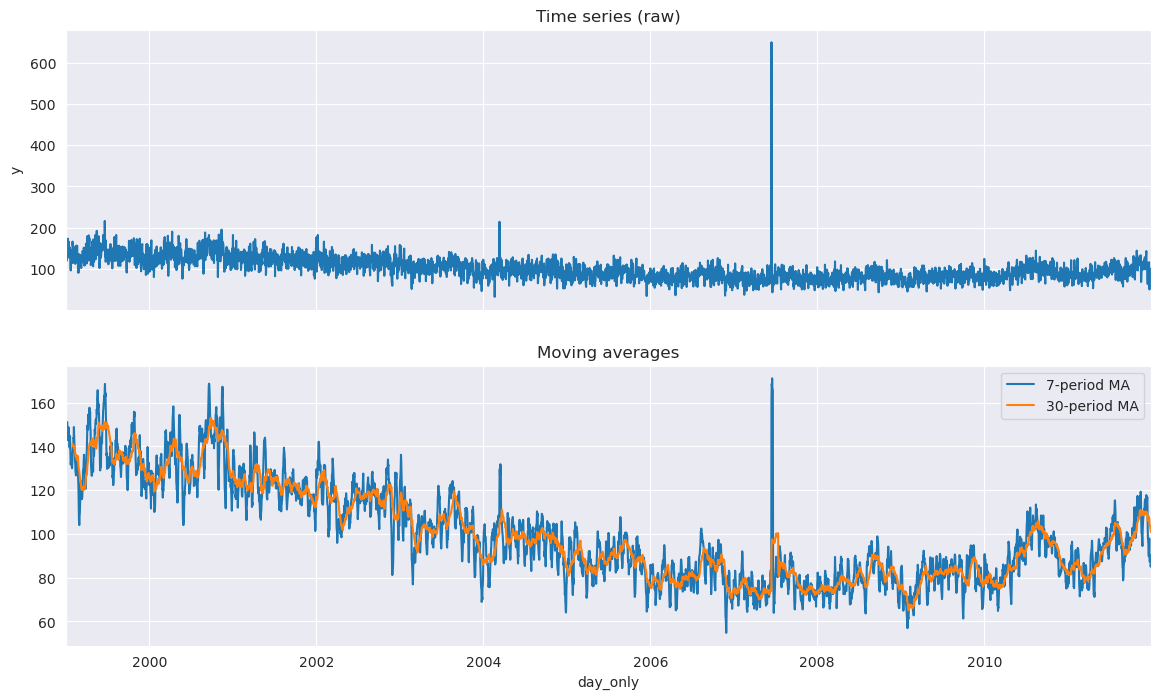

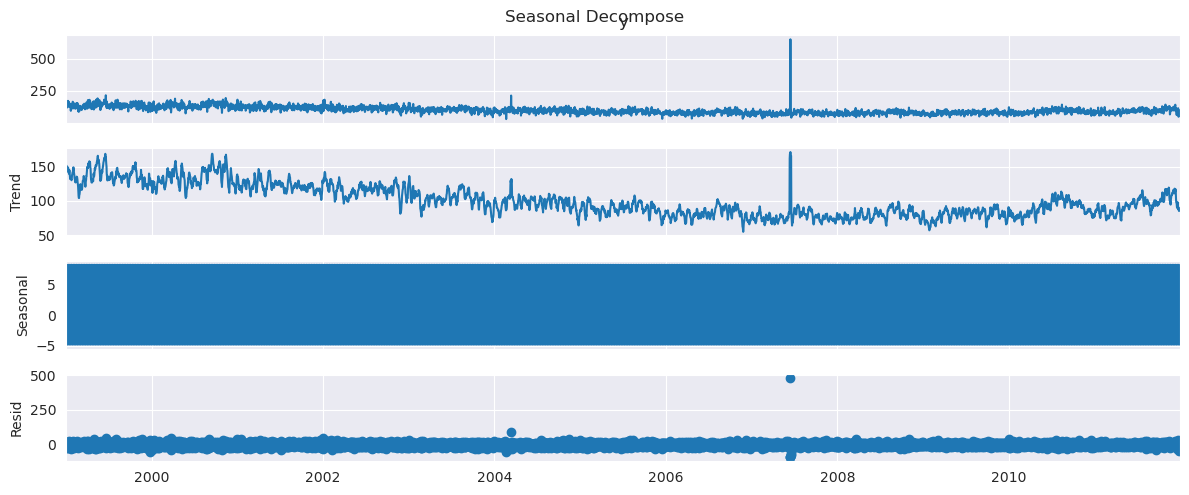


Augmented Dickey-Fuller test:
ADF Statistic: -2.6818
p-value: 0.0772
Critical Values:
 1%: -3.4317
 5%: -2.8622
 10%: -2.5671

Train length: 4734 Test length: 14

Baseline evaluations:
Naive: {'MAE': 30.785714285714285, 'RMSE': np.float64(32.67043224166376), 'MAPE': np.float64(32.568470139395934)}
Seasonal naive: {'MAE': 24.5, 'RMSE': np.float64(32.45326309809671), 'MAPE': np.float64(32.10841574277348)}
SARIMAX evaluation: {'MAE': 17.31736432595833, 'RMSE': np.float64(21.37129456258058), 'MAPE': np.float64(22.701590190510803)}
XGBoost evaluation: {'MAE': 13.392266273498535, 'RMSE': np.float64(18.75833066886342), 'MAPE': np.float64(18.20525802603424)}


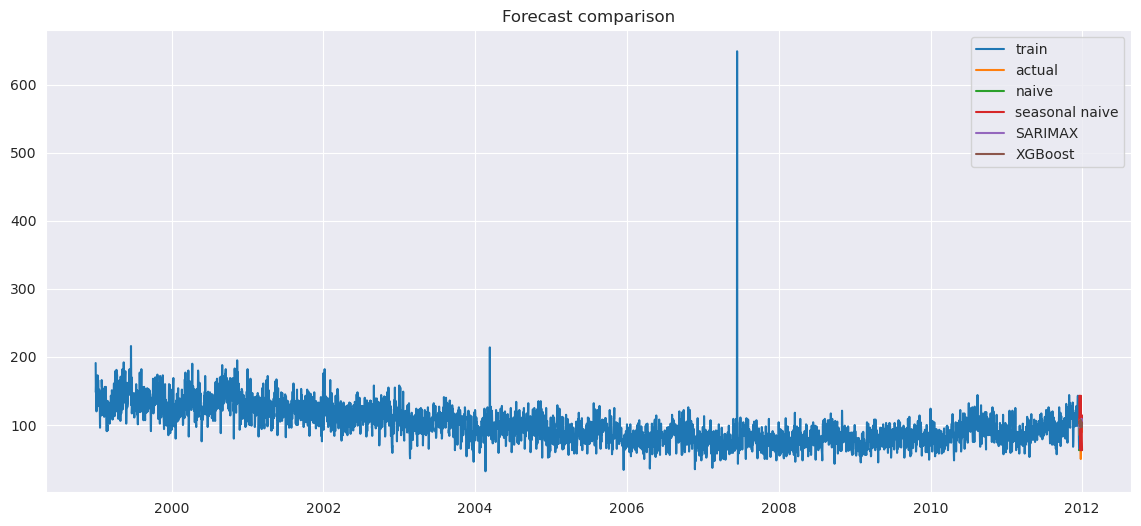

,feature,importance_mean,importance_std
9,roll_mean_30,0.398972,0.014432
5,roll_mean_7,0.143884,0.002799
0,lag_1,0.109227,0.008664
13,weekday,0.098396,0.002297
12,day,0.095589,0.004055
7,roll_mean_14,0.061320,0.001737
1,lag_2,0.044976,0.001851
4,lag_14,0.036369,0.003289
8,roll_std_14,0.035115,0.001554
10,roll_std_30,0.034354,0.000808


Saved XGBoost model to xgb_model.joblib

Done. Check plots and saved model files.


In [14]:
if __name__ == '__main__':
    res = run_pipeline()
    print('\nDone. Check plots and saved model files.')